In [1]:
import flamp
import numpy as np
import numpy.linalg as lin
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import sparse
from tqdm import tqdm

import matrix_functions as mf

flamp.set_dps(300)  # compute with this many decimal digits precision


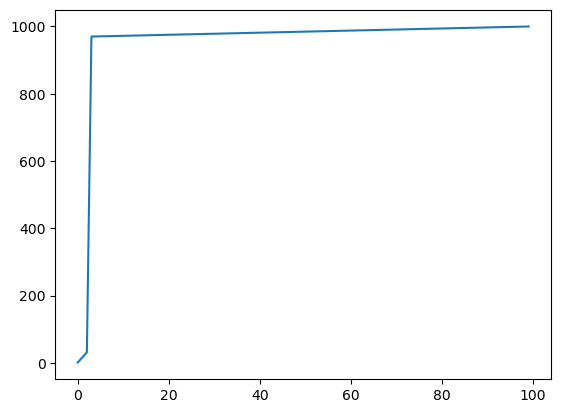

In [2]:
dim = 100
kappa = flamp.gmpy2.mpfr(1_000.)
lambda_min = flamp.gmpy2.mpfr(1.)
lambda_max = kappa * lambda_min

# a_diag = mf.flipped_model_spectrum(dim, kappa, 50, lambda_1=lambda_min)
a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_size=3, lambda_1=lambda_min)
# a_diag = mf.utils.linspace(lambda_min, lambda_max, num=dim)
# a_diag = mf.model_spectrum(dim, kappa, .9, lambda_1=lambda_min)
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_width=0.001, high_cluster_width=0.5, low_cluster_size=5, lambda_1=lambda_min)

A = mf.DiagonalMatrix(a_diag)
sqrtA = mf.DiagonalMatrix(flamp.sqrt(a_diag))

plt.plot(a_diag)

In [3]:
denom_deg = 2
def f(x):
    return x**(-denom_deg)
# f = flamp.sqrt # np.sqrt

# mu = a_diag[:-1] + np.diff(a_diag) / 2
# # mu = a_diag[1:] - np.diff(a_diag).min()/2
# x = mf.start_vec(a_diag, mu)

x = flamp.ones(dim)
# x = flamp.to_mp(np.flip(mf.model_spectrum(dim, kappa, 0.9)))
x[0] = 0.01

ground_truth = mf.diagonal_fa(f, a_diag, x)

# size of Krylov subspace
ks = list(range(1, dim, 10)) + [dim]

In [4]:
# Lanczos-FA
lanczos_errors = pd.Series(index=ks, dtype=np.float64)
for k, lanczos_estimate in tqdm(zip(ks, mf.lanczos_fa_multi_k(f, A, x, ks=ks, reorthogonalize=True))):
    lanczos_errors.loc[k] = mf.norm(lanczos_estimate - ground_truth)

11it [00:15,  1.43s/it]


In [5]:
# Optimal approximation to ground truth in Krylov subspace
# "Optimal" with respect to either Euclidean norm or A norm

krylov_basis, _ = mf.lanczos(A, x, reorthogonalize=True)

krylov_errors_2norm = pd.Series(index=ks, dtype=np.float64)
for k in tqdm(ks):
    # # _, squared_l2_error, _, _ = lin.lstsq(krylov_basis[:, :k], ground_truth, rcond=None)
    # # krylov_errors_2norm.append(np.sqrt(squared_l2_error.item()))
    _, residual = flamp.qr_solve(krylov_basis[:, :k], ground_truth, res=True)
    krylov_errors_2norm.loc[k] = mf.norm(residual)

krylov_errors_Anorm = pd.Series(index=ks, dtype=np.float64)
for k in tqdm(ks):
    _, residual = flamp.qr_solve(sqrtA @ krylov_basis[:, :k], sqrtA @ ground_truth, res=True)
    krylov_errors_Anorm.loc[k] = mf.norm(residual)

100%|██████████| 11/11 [00:02<00:00,  5.46it/s]


In [6]:
spectrum_discritization = mf.cheb_nodes(10 * dim, a=lambda_min, b=lambda_max, dtype=np.dtype('O'))
f_spectrum_discritization = f(spectrum_discritization)
CV = mf.cheb_vandermonde(spectrum_discritization, dim+1)

cheb_interpolant_errors = pd.Series(index=ks, dtype=np.float64)
for k in tqdm(ks):
    # Degree of polynomial must be strictly less than dimension of Krylov subspace used in Lanczos (so k - 1)
    cheb_interpolant = mf.cheb_interpolation(k - 1, f, lambda_min, lambda_max, dtype=np.dtype('O'))
    cheb_interpolant_error = mf.norm(cheb_interpolant(spectrum_discritization) - f_spectrum_discritization, ord=np.inf)
    cheb_interpolant_errors.loc[k] = 2 * mf.norm(x) * cheb_interpolant_error

cheb_regression_errors = pd.Series(index=ks, dtype=np.float64)
for k in tqdm(ks):
    cheb_coeffs = flamp.qr_solve(CV[:, :k], f_spectrum_discritization)
    # cheb_coeffs, _, _, _ = lin.lstsq(CV[:, :k], f_spectrum_discritization, rcond=None)
    cheb_regression_error = mf.norm(CV[:, :k] @ cheb_coeffs - f_spectrum_discritization, ord=np.inf)
    cheb_regression_errors.loc[k] = 2 * mf.norm(x) * cheb_regression_error


100%|██████████| 11/11 [00:28<00:00,  2.61s/it]


In [7]:
results = pd.DataFrame({
    "Lanczos-FA": lanczos_errors,
    "Krylov subspace": krylov_errors_2norm,
    # double check: is the factor of denom_deg necessary?
    "Our bound": denom_deg * (kappa ** denom_deg) * krylov_errors_Anorm,
    "Chebyshev interpolant $* 2||x||$": cheb_interpolant_errors,
    "Chebyshev regression $* 2||x||$": cheb_regression_errors
}, index=ks)

relative_error = True
if relative_error:
    # notice that it's relative to the *Euclidean* norm of the ground truth
    results /= mf.norm(ground_truth)
    error_label = "Relative Error"
else:
    error_label = "Error"

In [8]:
assert (results != flamp.gmpy2.mpfr('nan')).all().all()
assert (~pd.isna(results)).all().all()

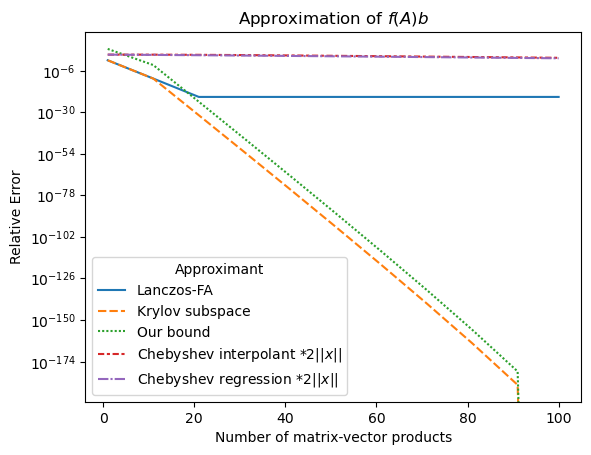

In [9]:
results_long = results.reset_index(names="Number of matrix-vector products").melt(
    id_vars=["Number of matrix-vector products"], value_name=error_label, var_name="Approximant")

sns.lineplot(x="Number of matrix-vector products", y=error_label, hue="Approximant", style="Approximant", data=results_long).set(
    title=f'Approximation of $f(A)b$',
    yscale='log'
);

plt.savefig('output/convergence.svg')

In [10]:
# import scipy.special as sps

# def tyler_inv_sqrt(q, a, b):
#     # In the sidford paper, the approximation is valid in the range [gamma, 1]
#     # that corresponds to [min(abs(lam)), max(abs(lam))] / max(abs(lam))
#     # since sidford's gamma =tyler's sqrt(k2)

#     # lmin = np.min(np.abs(lam))**2
#     # lmax = np.max(np.abs(lam))**2
#     assert 0 < a < b 
#     lmin = a ** 2
#     lmax = b ** 2

#     poles = flamp.zeros(q)
#     weights = flamp.zeros(q)

#     k2 = lmin/lmax  # this is called gamma^2 in the Sidford paper
#     Kp = sps.ellipk(1-k2)  # this is called K prime in the Sidford paper

#     t = 1j*np.arange(1/2,q+1/2)*Kp/q

#     sn_,cn_,dn_,_ = sps.ellipj(np.imag(t),1-k2) # compute real valued functions to transform to what we need

#     cn = 1/cn_
#     dn = dn_ / cn_
#     sn = 1j * sn_ / cn_

#     poles = np.real(lmin * sn**2)

#     weights = (2 * Kp * flamp.sqrt(lmin))/(flamp.gmpy2.const_pi()*q) * (cn * dn)

#     return lambda x: np.sum( weights / (x[:,None]-poles) ,axis=1)

In [11]:
# import baryrat

# running_best_rational_bound = np.inf
# best_rational_bounds = []
# for k in range(99):
#     if k >= 2:
#         ##### WARNING! DON"T HARD CODE THE FUNCTION OK!
#         # aaa_interpolant = baryrat.aaa(np.array(spectrum_discritization, float), np.sqrt, mmax=(k//2))
#         # error = mf.norm(aaa_interpolant(spectrum_discritization) - np.array(f_spectrum_discritization, float), ord=np.inf)
#         # deg_k_error = (kappa ** (k//2)) * error
#         inv_sqrt = tyler_inv_sqrt((k//2), spectrum_discritization.min(), spectrum_discritization.max())
#         zolotarev_interpolant = lambda x: 1./inv_sqrt(x)
#     else:
#         deg_k_error = np.inf

#     running_best_rational_bound = min(running_best_rational_bound, deg_k_error)
#     best_rational_bounds.append(running_best_rational_bound)

# results['rational'] = np.array([min(best_rational_bound[:(k+1)]) for k in ks], dtype=float)

In [12]:
# rational_bound_all_q = []
# for q in range(2,20):
#     rq_inv_sqrt = tyler_inv_sqrt(q, lambda_min, lambda_max)
#     rational_bound_q = []
#     for k in ks:
#         rational_approx_error = mf.norm(f(spectrum_discritization) - 1./rq_inv_sqrt(spectrum_discritization), ord=np.inf)
#         _, residual = flamp.qr_solve(krylov_basis[:, :k], mf.diagonal_fa(rq_inv_sqrt, a_diag, x), res=True) # uh-oh, this is 2-norm optimal, not A-norm optimal
#         krylov_error = mf.norm(residual, ord=np.inf)
#         rational_bound_q.append(rational_approx_error + (kappa ** q) * krylov_error)
#     rational_bound_all_q.append(rational_bound_q)

# results['other'] = np.array(rational_bound_all_q, float).min(axis=0)